# Zillow Price Prediction
By Parker Voit

### Project Goals
- Predict tax values of single unit properties with a transaction during the months of May - August 2017. 
    - Also predict tax rate distributions for each county code included
    - identify the state and county the data is located in 

### Project Planning
- Create a detailed README.md for with project goals, data dictionary, hypothesis with testing results, and anything else needed for reproducibility
- Acquire single unit property data with a transaction date between May and August 2017
- Prep data by dropping duplicates, nulls, and data points more than 3 standard deviations away
- Will need to scale data, too
- Look up FIPS codes and calculate tax rate to determine distributions
- Use visualizations and stats to determine drivers of property cost
- Develop hypotheses for drivers
- Create baselines and choose best based off of RMSE
- Determine type of regression based off of target distribution
- Choose best performing model based off of findings
- Improve on MVP through feature engineering and automated feature selection

## Acquire


In [1]:
import math
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.feature_selection import SelectKBest, f_regression, chi2, RFE
from sklearn.metrics import explained_variance_score, mean_squared_error, r2_score
import sklearn.preprocessing
from env import username, host, password
import acquire, prepare, explore, evaluate

In [2]:
# function pulls all single family residential properties from may-august 2017
zillow_df = acquire.get_zillow_db()

In [3]:
zillow_df.describe().apply(lambda x: x.apply('{0:.2f}'.format)).T

,count,mean,std,min,25%,50%,75%,max
parcelid,28124.00,13042388.38,3747699.81,10711855.00,11513802.75,12596700.00,14149137.75,167687839.00
bed,28124.00,3.31,0.94,0.00,3.00,3.00,4.00,12.00
bath,28124.00,2.32,1.02,0.00,2.00,2.00,3.00,11.00
sqft,28077.00,1934.93,995.68,240.00,1278.00,1675.00,2326.00,17245.00
tax_value,28123.00,535004.92,707681.06,1000.00,198636.00,382798.00,632767.00,23858374.00
yearbuilt,28053.00,1963.77,23.11,1878.00,1950.00,1961.00,1979.00,2016.00
taxamount,28123.00,6508.83,8221.72,51.26,2705.33,4735.28,7528.40,276797.83
fips,28124.00,6049.52,21.30,6037.00,6037.00,6037.00,6059.00,6111.00


In [4]:
zillow_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28124 entries, 0 to 28123
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   parcelid   28124 non-null  int64  
 1   bed        28124 non-null  float64
 2   bath       28124 non-null  float64
 3   sqft       28077 non-null  float64
 4   tax_value  28123 non-null  float64
 5   yearbuilt  28053 non-null  float64
 6   taxamount  28123 non-null  float64
 7   fips       28124 non-null  float64
dtypes: float64(7), int64(1)
memory usage: 1.9 MB


In [5]:
acquire.missing_values_table(zillow_df)

Your selected dataframe has 8 columns.
There are 4columns that have missing values.


,Missing Values,% of Total Values
yearbuilt,71,0.3
sqft,47,0.2
tax_value,1,0.0
taxamount,1,0.0


#### Takeaways
> - Parcelid can be excluded from data since it's an ID number.
> - FIPS is a unique code for counties, these are LA, Orange, and Ventura counties in California. It is a categorical variable
> - bed, bath, and sqft need to be scaled
> - tax rate can be calculated by dividing tax_value by taxamount. 

## Prepare

In [6]:
# begin by dropping nulls, duplicates, and outliers
zillow_df = prepare.prep_df(zillow_df, 'tax_value' )

In [7]:
# add county
zillow_df['county'] = zillow_df['fips'].replace(to_replace = [6037, 6059, 6111], value = ['LA','Orange','Ventura'])
zillow_df['encoded_county'] = zillow_df['fips'].replace(to_replace = [6037, 6059, 6111], value = [0, 1, 2])

In [8]:
# calculate tax rate for future distribution 
zillow_df['tax_rate'] = zillow_df['taxamount']/zillow_df['tax_value']
zillow_df['tax_rate_cent'] = (zillow_df['taxamount']/zillow_df['tax_value']) * 100

In [9]:
# describe the new df
zillow_df.describe().apply(lambda x: x.apply('{0:.2f}'.format)).T

,count,mean,std,min,25%,50%,75%,max
parcelid,27617.00,13034787.36,3545074.67,10711855.00,11503331.00,12606905.00,14149013.00,167639152.00
bed,27617.00,3.30,0.92,0.00,3.00,3.00,4.00,12.00
bath,27617.00,2.28,0.95,0.00,2.00,2.00,3.00,10.00
sqft,27617.00,1889.04,883.33,240.00,1273.00,1660.00,2288.00,11020.00
tax_value,27617.00,474910.20,408708.68,1000.00,195981.00,376813.00,615002.00,2642313.00
yearbuilt,27617.00,1963.58,22.95,1878.00,1950.00,1961.00,1979.00,2016.00
taxamount,27617.00,5820.45,4770.37,51.26,2675.83,4668.36,7322.89,61992.63
fips,27617.00,6049.53,21.30,6037.00,6037.00,6037.00,6059.00,6111.00
zscore,27617.00,-0.08,0.58,-0.76,-0.48,-0.22,0.12,3.00
encoded_county,27617.00,0.45,0.65,0.00,0.00,0.00,1.00,2.00


#### Cleaning Takeaways
> Total rows went from 28124 entries to 27617. Not a bad loss

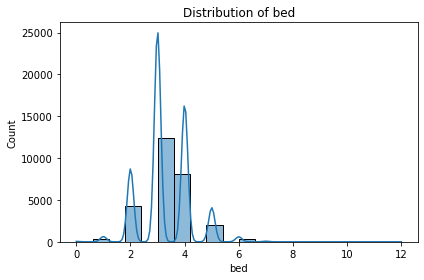

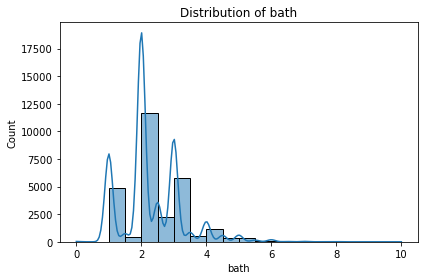

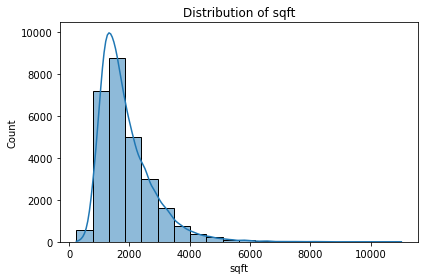

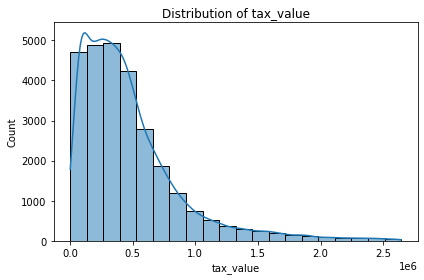

In [10]:
for x in zillow_df[['bed','bath','sqft','tax_value']]:
    sns.histplot(zillow_df[x], bins = 20, kde = True)
    plt.title(f'Distribution of {x}')
    plt.tight_layout()
    plt.show()

#### Distribution Takeaway
> tax_value is not normally distributed, will probably have to do a polynomial regression

### Project Deliverable 
Tax Rates by County

Text(0.5, 1.0, 'Distributions of Tax Rates by County')

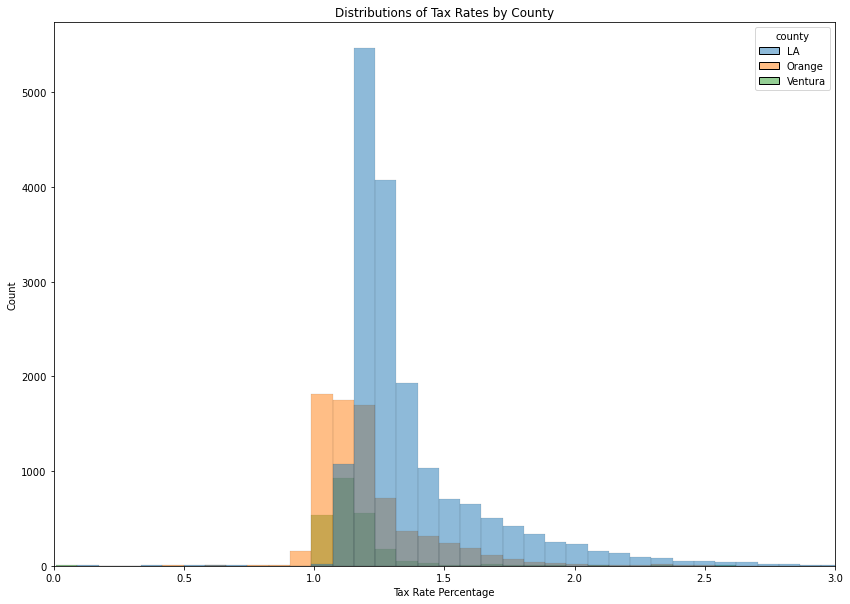

In [11]:
# distribution of tax rates by county
plt.figure(figsize=(14,10))
sns.histplot(data=zillow_df, x='tax_rate_cent', hue='county', bins = 1000)
plt.xlim(0.0, 3)
plt.xlabel('Tax Rate Percentage'.format(x))
plt.title('Distributions of Tax Rates by County')

#### Takeaway
> - LA has the most houses sold during the hot months, and is the farthest right skewed
> - Orange county is more tightly distributed, with most values between 1% and 1.5%
> - Ventura has the lowest count but is the most normally distributed

In [12]:
# Split data before scaling so we can fit the model to x train
train, validate, test = prepare.train_validate_test_split(zillow_df)
X_train = train[['bed','bath','sqft']]
X_validate = validate[['bed','bath','sqft']]
X_test = test[['bed','bath','sqft']]
y_train = pd.DataFrame(train['tax_value'])
y_validate = pd.DataFrame(validate['tax_value'])
y_test = pd.DataFrame(test['tax_value'])

In [13]:
# scale using minmax scaler
X_train_scaled = prepare.minmax_scale(X_train, X_train)
X_validate_scaled = prepare.minmax_scale(X_validate, X_train)
X_test_scaled = prepare.minmax_scale(X_test, X_train)

Data Dictionary:
- bed : number of bedrooms in the house 
- bath : number of bathrooms in the house. It is measured in increments of .5
- sqft : calculated square footage of the house. This was used over other square footage columns due to the completeness of the column. 
- tax_value : the data target we are trying to predict. It is the assessed tax value in USD. 
- fips/county : info was found from the USDA [website](https://www.nrcs.usda.gov/wps/portal/nrcs/detail/national/home/?cid=nrcs143_013697). Codes are as follows:
    - 6037 = Los Angeles(LA) County, California
    - 6059 = Orange County, California
    - 6111 = Ventura County, California

## Data Exploration

### Establish initial hypotheses 
> 1. I believe that tax rates will be correlated with square footage and as an extension bedroom and bathroom count
> 2. I believe that tax rates will significantly vary between the counties

In [14]:
# create dataframes seperated by county
la_df = train[train['county'] == 'LA']
orange_df = train[train['county'] == 'Orange']
vent_df = train[train['county'] == 'Ventura']

In [15]:
stats.normaltest(la_df['tax_value'])

NormaltestResult(statistic=4422.324664177488, pvalue=0.0)

In [16]:
stats.normaltest(orange_df['tax_value'])

NormaltestResult(statistic=1344.724970203391, pvalue=9.923911475638716e-293)

In [17]:
stats.normaltest(vent_df['tax_value'])

NormaltestResult(statistic=381.6070227145728, pvalue=1.3648593202249438e-83)

> all values are not normal. Must use a non-parametric test (mann-witney U)

**Hypothesis 1 -** Null rejected using a Mann-Whitney U test
- alpha = .05
- $H_0$: The tax_rate in LA is not different than the mean rates in Ventura and Orange counties. 
- $H_a$: The tax_rate in LA is different than the mean rates in Ventura and Orange counties.

In [18]:
# test LA mean tax value against the tax values of the other two counties
stats.mannwhitneyu(la_df['tax_value'], train[train['county'] != 'LA']['tax_value'])

MannwhitneyuResult(statistic=21434382.0, pvalue=9.386280990934584e-122)

**Hypothesis 2 -** Null rejected using a Mann-Whitney U test
- alpha = .05
- $H_0$: The tax_rate in Ventura is not different than the mean rates in LA and Orange counties. 
- $H_a$: The tax_rate in Ventura is different than the mean rates in LA and Orange counties. 

In [19]:
# test Orange County mean tax value against the tax values of the other two counties
stats.mannwhitneyu(orange_df['tax_value'], train[train['county'] != 'Orange']['tax_value'])

MannwhitneyuResult(statistic=18732552.0, pvalue=2.2071541196202066e-96)

**Hypothesis 3 -** Null rejected using a Mann-Whitney U test
- alpha = .05
- $H_0$: The tax_rate in Orange is not different than the mean rates in Ventura and LA counties. 
- $H_a$: The tax_rate in Orange is different than the mean rates in Ventura and LA counties. 

In [20]:
# # test LA mean tax value against the tax values of the other two counties
stats.mannwhitneyu(vent_df['tax_value'], train[train['county'] != 'Ventura']['tax_value'])

MannwhitneyuResult(statistic=8536186.0, pvalue=1.493642128460646e-12)

#### Means Testing Takeaways
> all p values are below .05, thus we can reject the null and confirm that the mean tax rates vary significantly between counties.

**Hypothesis 4 -** Null rejected using Pearson's R test
- alpha = .05
- $H_0$: Tax_rate is not correlated with square footage. 
- $H_a$: Tax_rate is correlated with square footage.

In [21]:
# pearsons test comparing square footage and tax value
stats.pearsonr(X_train_scaled['sqft'],y_train['tax_value'])

(0.6102466214688695, 0.0)

**Hypothesis 5 -** Null rejected using Pearson's R test
- alpha = .05
- $H_0$: Tax_rate is not correlated with bedrooms. 
- $H_a$: Tax_rate is correlated with bedrooms. 

In [22]:
# pearsons test comparing bedrooms and tax value
stats.pearsonr(X_train_scaled['bed'],y_train['tax_value'])

(0.29759060761156053, 9.341947129e-314)

**Hypothesis 6 -** Null rejected using Pearson's R test
- alpha = .05
- $H_0$: Tax_rate is not correlated with bathrooms footage. 
- $H_a$: Tax_rate is correlated with bathrooms. 

In [23]:
stats.pearsonr(X_train_scaled['bath'],y_train['tax_value'])

(0.5373914315198056, 0.0)

#### Correlation Testing Takeaways
> Bedrooms, bathrooms, and square footage all had p values less than .05, indicating that they are all correlated with tax_value

### Exploration visualizations

<AxesSubplot:>

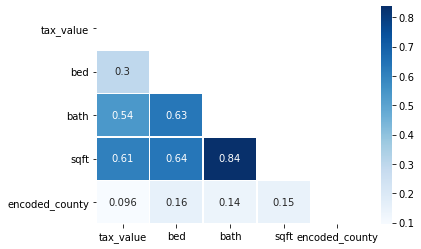

In [24]:
explore.heat_corr(train[['tax_value','bed','bath','sqft','encoded_county']])

#### Heatmap takeaway
> - The county ended up being the weakest driver for depicting tax_value despite having significantly different means from each other.
> - Both square footage and bathrooms have stronger correlations. 
> Bed is somewhat weak, but can be included in the list of features

<Figure size 720x720 with 0 Axes>

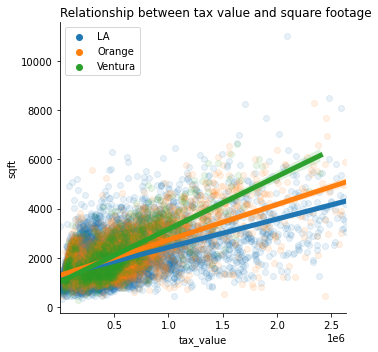

In [25]:
plt.figure(figsize = (10,10))
sns.lmplot(x = 'tax_value', y = 'sqft', data = train, hue = 'county', scatter_kws = {'alpha': 0.1}, line_kws ={'alpha': 2, 'linewidth' : 5}, legend = False)
leg = plt.legend()
for lh in leg.legendHandles: 
    lh.set_alpha(1)
plt.title('Relationship between tax value and square footage', loc = 'left')
plt.tight_layout()
plt.show()

#### Scatter Plot Takeaway 
> - Tax value has a positive correlation with square footage for all counties
> - Ventura seems closest fit to a simple regression between counties
> - LA county has quite a bit of variance and seems like the one with the highest error 

### Exploration Takeaways
> - Square footage, bedroom count, and bathroom count are the strongest drivers of tax value
> - Location by county is not very strong at all
> - We will use the top 3 features in our regression model

## Modeling

In [26]:
# Mean is the stronger baseline with this data set
train['mean_baseline'] = train['tax_value'].mean()

In [27]:
# evaluate baseline to determine baseline metrics. Score to beat is RMSE = 40739
evaluate.baseline_mean_errors(train['tax_value'])

|Sum of Squared Errors: 2.567e+15
|-----------------------------------
|Mean Squared Error : 1.66e+11
|-----------------------------------
|Root Mean Squared Error : 4.074e+05


(None, None, None, None, None)

In [28]:
# Feature selection to determine top values, also to confirm visual analysis
explore.select_kbest(X_train_scaled, y_train)

The best features are:['bed', 'bath', 'sqft']


In [29]:
explore.rfe(X_train_scaled, y_train, k = 3)

Best features are ['bed', 'bath', 'sqft']


> features selected are bedroom count, bathroom count, and square footage

#### OLS regression

In [30]:
# create linear model. Normalize set to either true or false does not affect the model's performance
lm = LinearRegression(normalize=True)

# fit model to scaled train dataset
lm.fit(X_train_scaled, y_train.tax_value)

# save predictions in the target train dataframe
y_train['pred_lm'] = lm.predict(X_train_scaled)

# calculate rmse 
rmse_train = mean_squared_error(y_train.tax_value, y_train.pred_lm)**(1/2)

# replicate and save prediction the validate dataframe
y_validate['pred_lm'] = lm.predict(X_validate_scaled)
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.pred_lm)**(1/2)

print("RMSE for OLS using LinearRegression\nTraining RMSE: ", rmse_train, 
      "\nValidation RMSE: ", rmse_validate)

RMSE for OLS using LinearRegression
Training RMSE:  317591.3467458347 
Validation RMSE:  316865.5998922466


In [31]:
# determine if model is better than train baseline
evaluate.better_than_baseline(y_train.tax_value, y_train.pred_lm)

,metric,model_error,base_error,model_efficacy
0,SSE,1.559866e+15,2.566729e+15,True
1,MSE,1.008643e+11,1.659702e+11,True
2,RMSE,3.175913e+05,4.073944e+05,True


In [32]:
# get regression stats for the model 
evaluate.regression_stats(y_train.tax_value, y_train.pred_lm)

|Slope of Regression: 0.3923
|-----------------------------------
|Regression intercept: 2.868e+05
|-----------------------------------
|r² = 0.39
|-----------------------------------
|p value = 0.0
|-----------------------------------
|Standard error : 0.003926


(None, None, None, None, None, None, None, None, None)

In [33]:
# evaluate model on the validate set
evaluate.better_than_baseline(y_validate.tax_value, y_validate.pred_lm)

,metric,model_error,base_error,model_efficacy
0,SSE,6.654764e+14,1.098350e+15,True
1,MSE,1.004038e+11,1.657136e+11,True
2,RMSE,3.168656e+05,4.070794e+05,True


In [34]:
# get stats for the model uing the validate set
evaluate.regression_stats(y_validate.tax_value, y_validate.pred_lm)

|Slope of Regression: 0.4077
|-----------------------------------
|Regression intercept: 2.77e+05
|-----------------------------------
|r² = 0.39
|-----------------------------------
|p value = 0.0
|-----------------------------------
|Standard error : 0.006202


(None, None, None, None, None, None, None, None, None)

#### OLS Takeaways
> - Linear model does better than the baseline in both data sets
> - Model has slightly less error in the train set versus the validate, implying it is slightly overfit
> - r2 is on the weaker side, but it is a good start

#### LASSO + LARS

In [35]:
# create model
lars = LassoLars(alpha=1.0)

# fit model object to scaled data set. 
lars.fit(X_train_scaled[['bed','bath','sqft']], y_train.tax_value)

# save predictions in the target train dataframe
y_train['pred_lars'] = lars.predict(X_train_scaled[['bed','bath','sqft']])

# calculate rmse
rmse_train = mean_squared_error(y_train.tax_value, y_train.pred_lars)**(1/2)

# save predictions in the target validate dataframe
y_validate['pred_lars'] = lars.predict(X_validate_scaled[['bed','bath','sqft']])

# calculate rmse
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.pred_lars)**(1/2)
print("RMSE for Lasso + Lars\nTraining: ", rmse_train, 
      "\nValidation: ", rmse_validate)

RMSE for Lasso + Lars
Training:  317591.49729632493 
Validation:  316867.1518586373


In [36]:
# determine if model is better than train baseline
evaluate.better_than_baseline(y_train.tax_value, y_train.pred_lars)

,metric,model_error,base_error,model_efficacy
0,SSE,1.559867e+15,2.566729e+15,True
1,MSE,1.008644e+11,1.659702e+11,True
2,RMSE,3.175915e+05,4.073944e+05,True


In [37]:
# get regression stats for the lasso model
evaluate.regression_stats(y_train.tax_value, y_train.pred_lars)

|Slope of Regression: 0.392
|-----------------------------------
|Regression intercept: 2.869e+05
|-----------------------------------
|r² = 0.39
|-----------------------------------
|p value = 0.0
|-----------------------------------
|Standard error : 0.003924


(None, None, None, None, None, None, None, None, None)

In [38]:
# determine if model is better than the validate baseline
evaluate.better_than_baseline(y_validate.tax_value, y_validate.pred_lars)

,metric,model_error,base_error,model_efficacy
0,SSE,6.654830e+14,1.098350e+15,True
1,MSE,1.004048e+11,1.657136e+11,True
2,RMSE,3.168672e+05,4.070794e+05,True


In [39]:
# get regression stats
evaluate.regression_stats(y_validate.tax_value, y_validate.pred_lars)

|Slope of Regression: 0.4074
|-----------------------------------
|Regression intercept: 2.771e+05
|-----------------------------------
|r² = 0.39
|-----------------------------------
|p value = 0.0
|-----------------------------------
|Standard error : 0.006198


(None, None, None, None, None, None, None, None, None)

#### LASSO + LARS Takeaway
> - This model performs slightly worse than the OLS model 
> - Still performs better than the baseline
> - r2 is worse than the OLS model
> - model is overfit like the linear model

#### Polynomial Regression Model

In [40]:
# going to go with a polynomial model due to target distribution. Degree of 3 was found to be most effective hyperparameter.
pf = sklearn.preprocessing.PolynomialFeatures(degree=3)

# fit and transform X_train_scaled 
X_train_degree3 = pf.fit_transform(X_train_scaled[['bed','bath','sqft']])

# transform X_validate_scaled & X_test_scaled
X_validate_degree3 = pf.transform(X_validate_scaled[['bed','bath','sqft']])
X_test_degree3 = pf.transform(X_test_scaled[['bed','bath','sqft']])

In [41]:
# Create model
lm = LinearRegression(normalize=True)

#fit the model to the transformed X_train. use the unmodified y_train.tax_value as a target
lm.fit(X_train_degree3, y_train.tax_value)

# create a prediction and save to y_train
y_train['pred_lr'] = lm.predict(X_train_degree3)

#calculate RMSE

rmse_train = mean_squared_error(y_train.tax_value, y_train.pred_lr)**(1/2)

# create prediction and save to y_validate
y_validate['pred_lr'] = lm.predict(X_validate_degree3)

# calculate RMSE
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.pred_lr)**(1/2)

print("RMSE for PolyRegression \nTraining: ", rmse_train, 
      "\nValidation: ", rmse_validate)

RMSE for PolyRegression 
Training:  314121.59728373145 
Validation:  314393.9826546377


In [42]:
# determine if model is better than baseline
evaluate.better_than_baseline(y_train.tax_value, y_train.pred_lr)

,metric,model_error,base_error,model_efficacy
0,SSE,1.525968e+15,2.566729e+15,True
1,MSE,9.867238e+10,1.659702e+11,True
2,RMSE,3.141216e+05,4.073944e+05,True


In [43]:
# get regression stats of the model
evaluate.regression_stats(y_train.tax_value, y_train.pred_lr)

|Slope of Regression: 0.4055
|-----------------------------------
|Regression intercept: 2.806e+05
|-----------------------------------
|r² = 0.41
|-----------------------------------
|p value = 0.0
|-----------------------------------
|Standard error : 0.003948


(None, None, None, None, None, None, None, None, None)

In [44]:
# determine if it still works for the validate set
evaluate.better_than_baseline(y_validate.tax_value, y_validate.pred_lr)

,metric,model_error,base_error,model_efficacy
0,SSE,6.551352e+14,1.098350e+15,True
1,MSE,9.884358e+10,1.657136e+11,True
2,RMSE,3.143940e+05,4.070794e+05,True


In [45]:
# get the stats for the model applied to y_validate
evaluate.regression_stats(y_validate.tax_value, y_validate.pred_lr)

|Slope of Regression: 0.4134
|-----------------------------------
|Regression intercept: 2.749e+05
|-----------------------------------
|r² = 0.4
|-----------------------------------
|p value = 0.0
|-----------------------------------
|Standard error : 0.006169


(None, None, None, None, None, None, None, None, None)

#### Polynomial Regression Takeaway
> - The model performs better than baseline
> - This model performs the best out of the three models based off of error rates and r2
> - This model is also the least overfit 

### Modeling takeaway
> - Automated feature selection confirmed that bedroom count, bathroom count, and square footage were the 3 strongest driving features predicting tax value
    - County the residence is located in was not as strong of a driving factor than I originally anticipated
> - All of the models were effective at predicting tax values because they out-performed the baseline based off of RMSE and other model metrics
> - Polynomial regression was the best model due to it's low RMSE score relative to the other scores, relatively high r2, and being the least overfit
    - Setting the hyperparameter 'degrees' to 3 gave the best performance

### Test Predictions

In [46]:
#fit the model to the transformed X_train. use the unmodified y_test.tax_value as a target
lm.fit(X_train_degree3, y_train.tax_value)

# create a prediction and save to y_train
y_test['pred_lr'] = lm.predict(X_test_degree3)

#calculate RMSE

rmse_train = mean_squared_error(y_test.tax_value, y_test.pred_lr)**(1/2)

print("RMSE for PolyRegression \nTest: ", rmse_train)

RMSE for PolyRegression 
Test:  321442.39273552457


In [47]:
evaluate.better_than_baseline(y_test.tax_value, y_test.pred_lr)

,metric,model_error,base_error,model_efficacy
0,SSE,5.707685e+14,9.476542e+14,True
1,MSE,1.033252e+11,1.715522e+11,True
2,RMSE,3.214424e+05,4.141886e+05,True


In [48]:
evaluate.regression_stats(y_train.tax_value, y_train.pred_lr)

|Slope of Regression: 0.4055
|-----------------------------------
|Regression intercept: 2.806e+05
|-----------------------------------
|r² = 0.41
|-----------------------------------
|p value = 0.0
|-----------------------------------
|Standard error : 0.003948


(None, None, None, None, None, None, None, None, None)

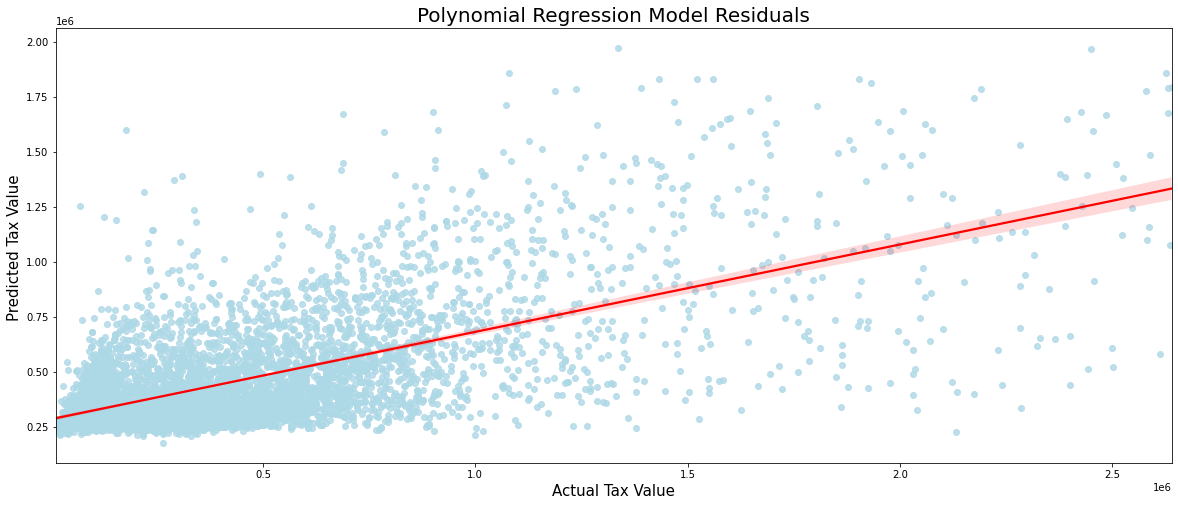

In [49]:
# visualize the residuals
plt.figure(figsize=(20,8))

# plot predicitons vs actual
sns.regplot(data=y_test, x=y_test.tax_value, y=y_test.pred_lr, 
            scatter_kws={'color':'lightblue'}, line_kws={'color':'red'})
plt.xlabel("Actual Tax Value", fontdict={'fontsize':15})
plt.ylabel("Predicted Tax Value ", fontdict={'fontsize':15})
plt.title("Polynomial Regression Model Residuals", fontdict={'fontsize': 20})

plt.show()


## Conclusions
- 3rd degree Polynomial Regression Model was the most effective with an r2 of .41
- Most effective drivers for predicting tax value were:
    - the number of bedrooms
    - the number of bathrooms
    - square footage
- County location was less impactful that initially hypothesized
- Mean error for the values are about $321,000 
    - this could be improved on with some more feature engineering. Perhaps plot size, construction type, or story type of the building are additional features to look at
    - The model does not predict as accurately when the actual tax value increases. This could be due to the aforementioned features
- Given more time, I would like to feature engineer construction date to see if it is a driver for predicting tax values
